In [117]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import hvplot.pandas  # noqa

import warnings
warnings.simplefilter(action='ignore', category=Warning)

Return Forecasting: Time Series Analysis & Modelling with BTC-USD Exchange rate data.


In this notebook, you will load historical Canadian Bitcoin-Usd exchange rate data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [118]:
# Currency pair exchange rates for BTC/USD
btc_usd_df = pd.read_csv(
    Path("Data/BTC-USD.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
btc_usd_df["Price"] = btc_usd_df["Price"].str.replace(",", "").copy()
btc_usd_df["Price"]=btc_usd_df["Price"].astype(float)
btc_usd_df.head()

Price      Open      High       Low    Vol. Change %
Date                                                              
2021-09-01  48762.0  47,129.2  49,121.0  46,533.1  70.38K    3.46%
2021-08-31  47130.4  46,989.1  48,217.0  46,709.3  71.48K    0.29%
2021-08-30  46992.7  48,777.1  48,886.0  46,876.9  61.68K   -3.66%
2021-08-29  48777.4  48,899.7  49,621.7  47,870.1  47.62K   -0.24%
2021-08-28  48897.1  49,062.8  49,289.4  48,428.5  36.73K   -0.34%

In [119]:
btc_usd_df = btc_usd_df.sort_index(ascending=True)
btc_usd_df.head()

Price     Open     High      Low     Vol. Change %
Date                                                           
2017-08-01  2747.0  2,883.3  2,946.0  2,659.6  123.17K   -4.73%
2017-08-02  2720.5  2,747.0  2,773.8  2,668.9   81.82K   -0.96%
2017-08-03  2810.0  2,720.5  2,822.9  2,717.6   68.10K    3.29%
2017-08-04  2878.5  2,810.0  2,892.7  2,779.5   68.76K    2.44%
2017-08-05  3262.8  2,878.5  3,344.0  2,875.9  159.40K   13.35%

In [120]:
 # Trim the dataset to begin on January 1st, 1990
btc_usd_df = btc_usd_df.loc["2018-01-01": , :]
btc_usd_df.head()

Price      Open      High       Low     Vol. Change %
Date                                                               
2018-01-01  13444.9  13,850.5  13,921.5  12,877.7   78.43K   -2.93%
2018-01-02  14754.1  13,444.9  15,306.1  12,934.2  137.73K    9.74%
2018-01-03  15156.6  14,754.1  15,435.0  14,579.7  106.54K    2.73%
2018-01-04  15180.1  15,156.5  15,408.7  14,244.7  110.97K    0.15%
2018-01-05  16954.8  15,180.1  17,126.9  14,832.4  141.96K   11.69%

Initial Time-Series Plotting; 
Start by plotting the "Settle" price to see if there is any patterns, long-term and/or short

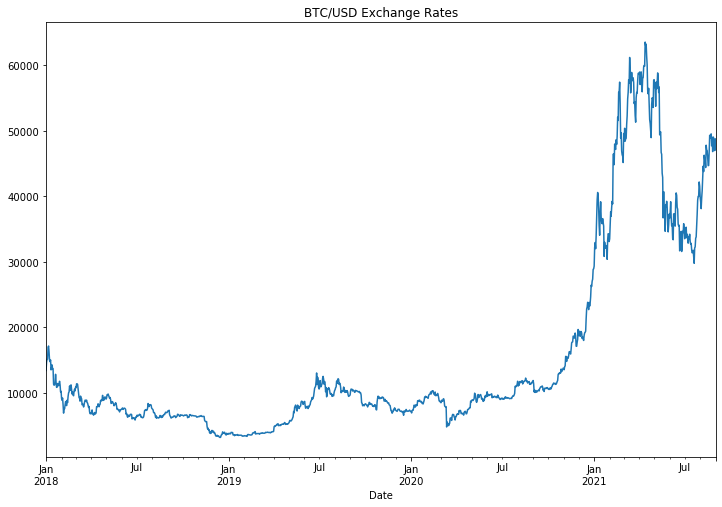

In [121]:
# Plot just the "Price" column from the dataframe:
btc_usd_df["Price"].plot(figsize=(12,8),title="BTC/USD Exchange Rates")

Decomposition Using a Hodrick-Prescott Filter


Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [122]:
import statsmodels.api as sm
from patsy import dmatrices
# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(btc_usd_df[["Price"]])

In [123]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
futures_decomp = btc_usd_df[["Price"]].copy()
futures_decomp["noise"] = ts_noise
futures_decomp["trend"] = ts_trend
futures_decomp.tail() 

Price        noise         trend
Date                                          
2021-08-28  48897.1   291.674137  48605.425863
2021-08-29  48777.4    81.317815  48696.082185
2021-08-30  46992.7 -1790.385964  48783.085964
2021-08-31  47130.4 -1738.362866  48868.762866
2021-09-01  48762.0  -192.319568  48954.319568

In [124]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
futures_decomp[["Price", "trend"]]["2017":].hvplot(figsize=(12, 8), title="Price vs. Trend")

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

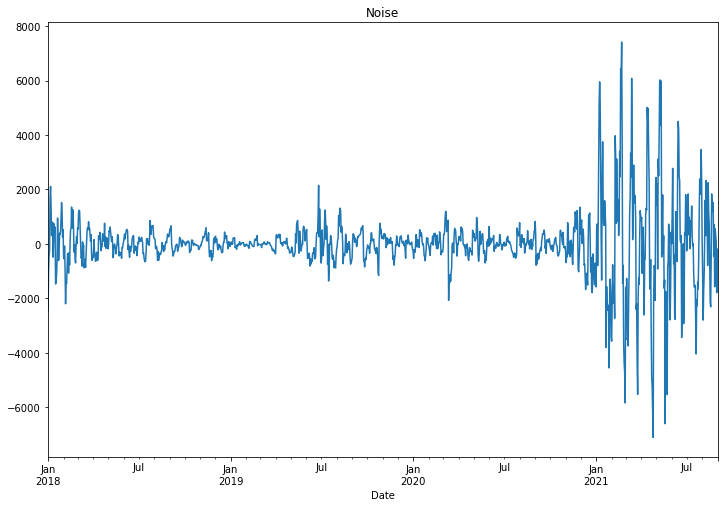

In [125]:
 # Plot the Settle Noise
ts_noise.plot(figsize=(12, 8), title="Noise")

Forecasting Returns using an ARMA Model


Using exchange rate Returns, estimate an ARMA model
ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
Plot the 30-day forecast of the forecasted returns (the results forecast from ARMA model)

In [126]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
#  multiply the pct_change() results by 100
#  replace inf, -inf values with np.nan"s
returns = (btc_usd_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.head()

Price
Date                 
2018-01-02   9.737521
2018-01-03   2.728055
2018-01-04   0.155048
2018-01-05  11.690964
2018-01-06   1.282823

In [127]:
import statsmodels.api as sm

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = sm.tsa.ARMA(returns, order=(2, 1))

# Fit the model and assign it to a variable called results
results = model.fit()

In [128]:
results.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Price   No. Observations:                 1339
Model:                     ARMA(2, 1)   Log Likelihood               -3770.501
Method:                       css-mle   S.D. of innovations              4.043
Date:                Thu, 02 Sep 2021   AIC                           7551.002
Time:                        11:48:09   BIC                           7577.000
Sample:                    01-02-2018   HQIC                          7560.742
                         - 09-01-2021                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1817      0.116      1.564      0.118      -0.046       0.409
ar.L1.Price     0.5036      0.255      1.973      0.048       0.003       1.004
ar.L2.Price     0.1054      0.029      3.642      0.000       0.049       0.162
ma.L1.Price    -0.5887      0.256     -2.299      0.021      -1.090      -0.087
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5090           +0.0000j            1.5090            0.0000
AR.2           -6.2860           +0.0000j            6.2860            0.5000
MA.1            1.6987           +0.0000j            1.6987            0.0000
-----------------------------------------------------------------------------
"""

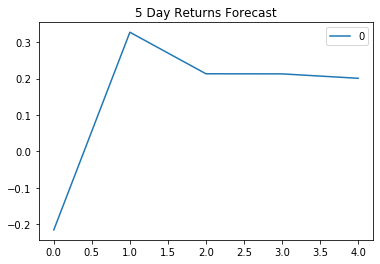

In [129]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

Forecasting the Exchange Rate Price using an ARIMA Model


Using the raw BTC/USD exchange rate price, estimate an ARIMA model.
Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
Plot a 30 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [130]:
 from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# ARIMA(df, order=(p, d, q))
model = ARIMA(btc_usd_df[["Price"]], order=(2, 1, 1))

# Fit the model
results = model.fit()

# Output model summary results:
results.summary()

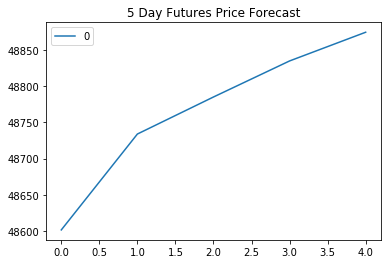

In [131]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast")

Volatility Forecasting with GARCH


 Volatility Forecasting with GARCH
Rather than predicting returns, let's forecast near-term volatility of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.

In [132]:
import arch as arch 

In [133]:
 # Estimate a GARCH model:
model = arch.arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)

# Fit the model
results = model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 6452.153748519095
Iteration:      2,   Func. Count:     11,   Neg. LLF: 164606801.4844621
Iteration:      3,   Func. Count:     16,   Neg. LLF: 3792.100461630087
Iteration:      4,   Func. Count:     21,   Neg. LLF: 491840182.71151775
Iteration:      5,   Func. Count:     26,   Neg. LLF: 3747.611797499364
Iteration:      6,   Func. Count:     31,   Neg. LLF: 3765.6089165739386
Iteration:      7,   Func. Count:     36,   Neg. LLF: 3725.798307273282
Iteration:      8,   Func. Count:     41,   Neg. LLF: 3722.2564490931854
Iteration:      9,   Func. Count:     45,   Neg. LLF: 3722.2473012513187
Iteration:     10,   Func. Count:     49,   Neg. LLF: 3722.247076358716
Iteration:     11,   Func. Count:     53,   Neg. LLF: 3722.2470241115398
Iteration:     12,   Func. Count:     57,   Neg. LLF: 3722.247005753715
Iteration:     13,   Func. Count:     61,   Neg. LLF: 3722.247005274212
Optimization terminated successfully    (Exit mode 0)
     

In [134]:
 # Summarize the model results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -3722.25
Distribution:                  Normal   AIC:                           7450.49
Method:            Maximum Likelihood   BIC:                           7466.09
                                        No. Observations:                 1339
Date:                Thu, Sep 02 2021   Df Residuals:                     1339
Time:                        11:48:12   Df Model:                            0
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.8619      0.487      1.771  7.660e-02 [-9.210e-02,  1.816]
alpha[1]       0.0620  3.220e-02      1.926  5.410e-02 [-1.093e-03,  0.125]
beta[1]        0.8857  4.665e-02     18.987  2.190e-80    [  0.794,  0.977]
===========================================================================

Covariance estimator: robust
"""

In [135]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2021-09-01'

In [136]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = results.forecast(start=last_day, horizon=forecast_horizon)

In [137]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

h.1        h.2        h.3        h.4        h.5
Date                                                             
2021-09-01  56.312677  56.767846  57.195884  57.598615  57.977716

In [139]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date  2021-09-01
h.1    56.312677
h.2    56.767846
h.3    57.195884
h.4    57.598615
h.5    57.977716

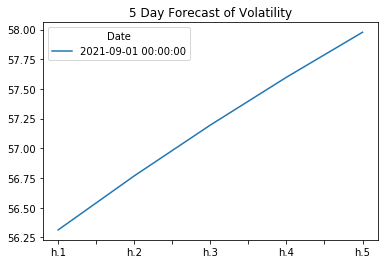

In [140]:
 # Plot the final forecast
final.plot(title="5 Day Forecast of Volatility")